In [1]:
p <- c("reshape2","ggplot2","pheatmap","combinat", "gridExtra",
       "cowplot", "UpSetR")
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep=TRUE, repos="https://cloud.r-project.org/")
  suppressWarnings(suppressMessages(invisible(require(p, character.only=TRUE))))
}
invisible(lapply(p, usePackage))

In [2]:
setwd('./')
outpath<-getwd()

In [4]:
f<-read.table("../Output/oral_2550_by_sex_RF.reg_out/feature_imps_all.xls", sep="\t", header=TRUE)

In [5]:
head(f)

Feature.ID,female,male,Taxon,Confidence
<fct>,<dbl>,<dbl>,<fct>,<dbl>
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,0.177215026,0.215246990,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptococcaceae; g__Peptococcus; s__,0.9999998
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTCTGTTAAGTCAGATGTGAAAGGTTAGGGCTCAACCCTGAACGTG,0.003737987,0.001204779,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptococcaceae; g__Peptococcus; s__,0.9999978
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGCGGGGAGGTTGATCCATTGTTAAAAGCATTTGCTTAACAAATGTGTGC,0.983180338,1.055092088,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,0.7451205
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTATGC,-0.000248058,0.004550409,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,0.8730009
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTGTGC,0.000701530,0.009376560,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,0.8538569
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTGTGG,0.000000000,0.000000000,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,0.8538160


In [35]:
names(f)
names(f)<-gsub("female", "Women", names(f))
names(f)<-gsub("male", "Men", names(f))
names(f)

[1] "Feature.ID" "Women"      "Men"        "Taxon"      "Confidence"

[1] "Feature.ID" "Women"      "Men"        "Taxon"      "Confidence"

In [36]:
rbind.na<-function(l){
    max_len<-max(unlist(lapply(l, length)))
    c_l<-lapply(l, function(x) {c(x, rep(NA, max_len - length(x)))})
    do.call(rbind, c_l)
}

In [37]:
taxa_df <- rbind.na(strsplit(as.character(f$Taxon), ';'))
colnames(taxa_df) <- c("kingdom", "phylum","class","order","family","genus","species")
head(taxa_df)

kingdom,phylum,class,order,family,genus,species
k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptococcaceae,g__Peptococcus,s__
k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptococcaceae,g__Peptococcus,s__
k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum
k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum
k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum
k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum


In [38]:
expand_Taxon<-function(df, Taxon){
    taxa_df <- rbind.na(strsplit(as.character(df[, Taxon]), ';'))
    colnames(taxa_df) <- c("kingdom", "phylum","class","order","family","genus","species")
    data.frame(df, taxa_df)
}
f_ann<-expand_Taxon(f, "Taxon")

In [39]:
dim(f_ann)

[1] 1070   12

In [40]:
## test rank
rank(-c(1, 2, 34, -1, NA), , na.last = "keep")
rank(c(1, 2, 34, -1, NA), , na.last = "keep")

[1]  3  2  1  4 NA

[1]  2  3  4  1 NA

In [41]:
library("dplyr")
f_ann_m<-melt(f_ann, id.vars = c("Feature.ID", "Taxon", "kingdom", "phylum", "class", "order", "family", "genus", "species", "Confidence"),
              variable.name = "Dataset", value.name = "imp")
f_ann_m<- f_ann_m %>% dplyr::group_by(Dataset) %>% mutate(imp_rank=rank(-imp, na.last = "keep"))
dim(f_ann_m)
head(f_ann_m)

[1] 2140   13

Feature.ID,Taxon,kingdom,phylum,class,order,family,genus,species,Confidence,Dataset,imp,imp_rank
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptococcaceae; g__Peptococcus; s__,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptococcaceae,g__Peptococcus,s__,0.9999998,Women,0.177215026,166.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTCTGTTAAGTCAGATGTGAAAGGTTAGGGCTCAACCCTGAACGTG,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptococcaceae; g__Peptococcus; s__,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptococcaceae,g__Peptococcus,s__,0.9999978,Women,0.003737987,533.0
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGCGGGGAGGTTGATCCATTGTTAAAAGCATTTGCTTAACAAATGTGTGC,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum,0.7451205,Women,0.983180338,60.0
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTATGC,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum,0.8730009,Women,-0.000248058,779.0
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTGTGC,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum,0.8538569,Women,0.000701530,638.0
AACATAGGTCACGAGCATTATCCGGATTTATTGGGCGTAAAGGAAGCGTAGGTGGGGAGGTTGATCCATTGTTAAAGGCATTTGCTTAACAAATGTGTGG,k__Bacteria; p__Tenericutes; c__Mollicutes; o__Mycoplasmatales; f__Mycoplasmataceae; g__Mycoplasma; s__haemominutum,k__Bacteria,p__Tenericutes,c__Mollicutes,o__Mycoplasmatales,f__Mycoplasmataceae,g__Mycoplasma,s__haemominutum,0.8538160,Women,0.000000000,717.5


In [42]:
#detach("package:plyr", unload=TRUE)
# f_ann_m[c(1:5, 9001:9005), ] %>% arrange(imp, Dataset)%>% group_by(Dataset) %>% mutate(imp_rank=rank(-imp, na.last = "keep"))

In [43]:
sum(f_ann_m$imp_rank==1, na.rm = T)

[1] 2

Warning message:
“Removed 94 rows containing missing values (geom_point).”

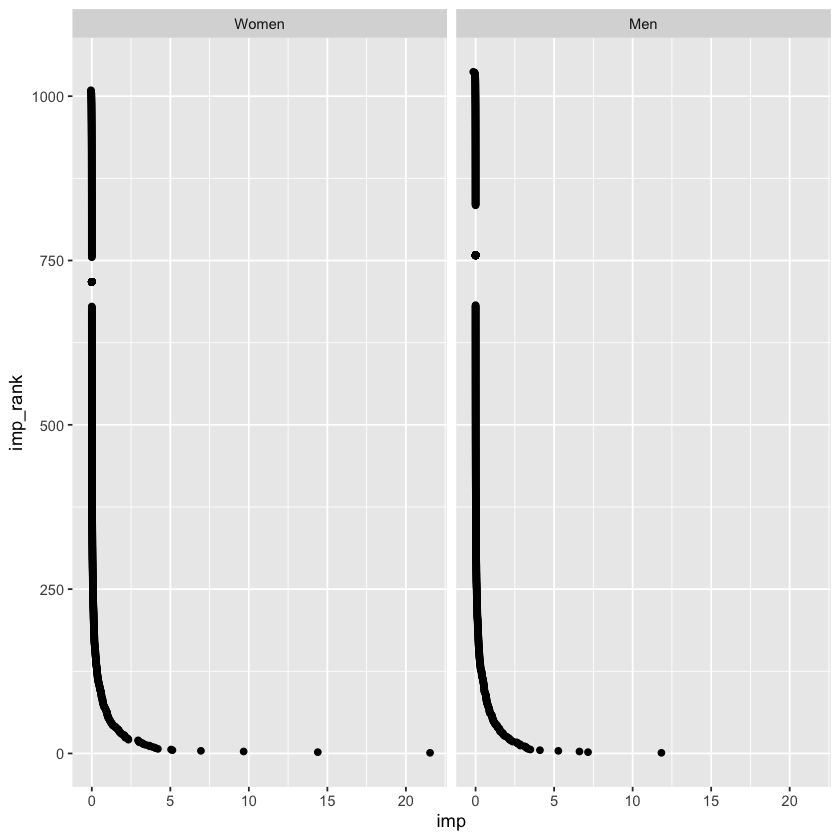

In [44]:
ggplot(f_ann_m, aes(x=imp, y=imp_rank))+geom_point()+facet_wrap(~Dataset)

### Order the Taxon (or genus) by sum of importance scores within the Taxonomy

In [45]:
f_ann_m$Taxon<-factor(f_ann_m$Taxon)

In [46]:
f_ann_m$genus<-factor(f_ann_m$genus)

In [47]:
dim(f_ann_m)

[1] 2140   13

### Imp socres collapsed to sOTUs' Taxonomy

In [48]:
library(dplyr)
Taxon_df<- f_ann_m %>% 
  dplyr::group_by(Taxon, Dataset) %>% 
  dplyr::summarise(n=length(imp), n_NA=sum(is.na(imp)), n_neg=sum(imp<0, na.rm = T), n_pos=sum(imp>0, na.rm = T), 
                   imp_sum = sum(imp, na.rm = T), imp_mean=mean(imp, na.rm = T), 
                   imp_rank_sum= sum(imp_rank, na.rm = T), imp_rank_mean=mean(imp_rank, na.rm = T),
                   imp_rank_min= min(imp_rank, na.rm = T))
cat("# of sum values: ", dim(Taxon_df)[1], '\n')
cat("# of Taxa: ", length(levels(f_ann_m$Taxon)))
Taxon_asc_levels<-levels(f_ann_m$Taxon)[with(Taxon_df,  order(imp_sum))]
Taxon_desc_levels<-levels(f_ann_m$Taxon)[with(Taxon_df,  order(-imp_sum))]

Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments to min; returning Inf”Warning message in min(imp_rank, na.rm = T):
“no non-missing arguments

# of sum values:  654 
# of Taxa:  327

In [49]:
head(Taxon_df)

Taxon,Dataset,n,n_NA,n_neg,n_pos,imp_sum,imp_mean,imp_rank_sum,imp_rank_mean,imp_rank_min
<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
k__Bacteria,Women,14,1,5,7,-0.009023347,-0.0006941036,9146.5,703.5769,508
k__Bacteria,Men,14,0,7,5,0.027036159,0.0019311542,10236.0,731.1429,362
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales,Women,2,0,0,2,0.008962594,0.0044812969,1034.0,517.0000,502
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales,Men,2,0,0,2,0.015057928,0.0075289640,930.0,465.0000,415
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Actinomycetaceae; g__; s__,Women,6,3,0,3,0.198351274,0.0661170912,1049.0,349.6667,171
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Actinomycetaceae; g__; s__,Men,6,0,0,2,0.568812060,0.0948020100,3494.0,582.3333,99


In [50]:
f_ann_m$Taxon<-factor(f_ann_m$Taxon,levels=Taxon_asc_levels, ordered=TRUE)
summary(f_ann_m$Taxon)

k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__ 
                                                                                                                         146 
                     k__Bacteria; p__Spirochaetes; c__Spirochaetes; o__Spirochaetales; f__Spirochaetaceae; g__Treponema; s__ 
                                                                                                                          84 
               k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Leptotrichiaceae; g__Leptotrichia; s__ 
                                                                                                                          80 
              k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__[Paraprevotellaceae]; g__[Prevotella]; s__ 
                                                                                                                          46 
                                             k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae 
                                                                                                                          44 
             k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Actinomycetaceae; g__Actinomyces; s__ 
                                                                                                                          42 
         k__Bacteria; p__Bacteroidetes; c__Flavobacteriia; o__Flavobacteriales; f__Flavobacteriaceae; g__Capnocytophaga; s__ 
                                                                                                                          32 
                                                                                                                 k__Bacteria 
                                                                                                                          28 
                        k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Selenomonas; s__ 
                                                                                                                          28 
              k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Fusobacteriaceae; g__Fusobacterium; s__ 
                                                                                                                          28 
                         k__Bacteria; p__Bacteroidetes; c__Flavobacteriia; o__Flavobacteriales; f__[Weeksellaceae]; g__; s__ 
                                                                                                                          26 
               k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Porphyromonas; s__ 
                                                                                                                          26 
        k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica 
                                                                                                                          24 
                               k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae 
                                                                                                                          24 
                                                                  k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales 
                                                                                                                          24 
                       k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Oribacterium; s__ 
                                                                                                                    

## heatmap of imp rank across datasets

### We visualized the imp rank of top-64 features with taxonomy annotations (such as species)

In [51]:
Taxon_df_top64<-subset(Taxon_df, imp_rank_min<64)
Taxon_df_top64_acast<-acast(Taxon_df_top64, Taxon~Dataset, value.var="imp_rank_min")
row_sum<-rowSums(Taxon_df_top64_acast, na.rm = T)
NA_perc<-rowSums(is.na(Taxon_df_top64_acast))/ncol(Taxon_df_top64_acast)
NA_perc_idx<-which(NA_perc<=0.5); taxa_kept<-names(NA_perc)[NA_perc_idx]
row_peudosum4NA<-rowMeans(Taxon_df_top64_acast, na.rm = T)*apply(Taxon_df_top64_acast, 1, function(x) sum(is.na(x)))
row_sum_comb<-row_sum+row_peudosum4NA
ord<-order(row_sum_comb, decreasing = F)
Taxon_df_top64$Taxon<-factor(Taxon_df_top64$Taxon,levels=rownames(Taxon_df_top64_acast)[ord], ordered=TRUE)

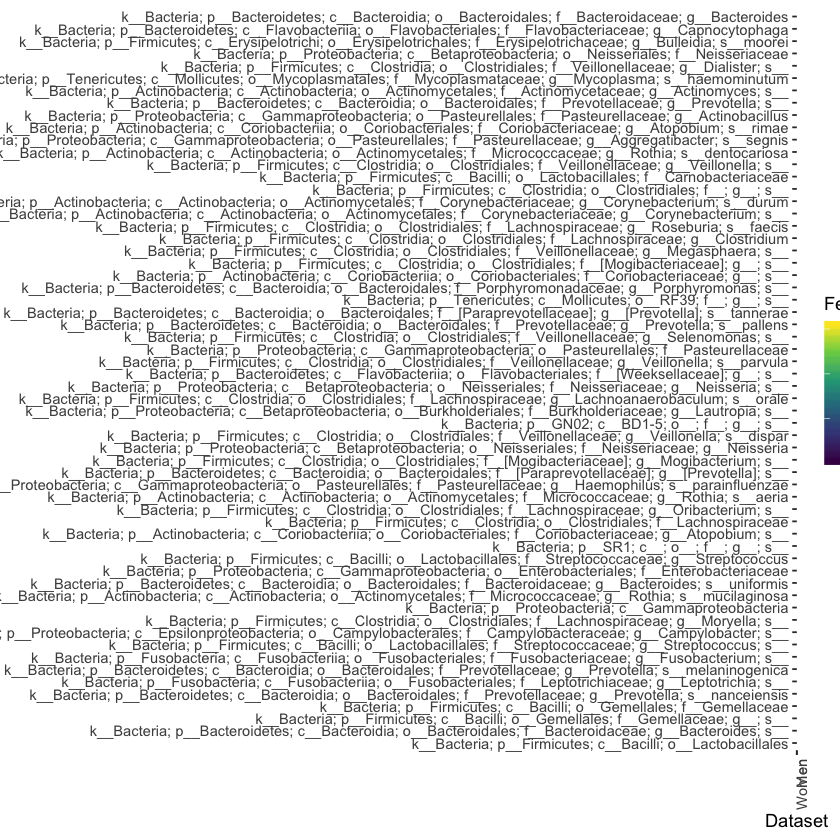

In [54]:
p<-ggplot(subset(Taxon_df_top64, Taxon %in% taxa_kept), aes(Dataset, Taxon) ) +
  geom_tile(data=subset(Taxon_df_top64, Taxon %in% taxa_kept), na.rm = FALSE, aes(fill = imp_rank_min), colour = 'white') + # adding "-" can switch the coloring
  geom_text(aes(label = round(imp_rank_min, 1)), color='white') +
  #scale_y_discrete(label=f_ann_m$Taxon)+
  scale_fill_continuous(type = "viridis", na.value = 'white')+
  labs(fill="Feature ranking")+
  #coord_flip()+
  theme(axis.text.x=element_text(angle=90,hjust=1))
p
#ggsave(filename=paste(outpath,"/oral_Top64_min_imp_rank_VS_dataset_heatmap.ggplot.pdf",sep=""),plot=p, width=10, height=10)
ggsave(filename=paste(outpath,"/Figure_S3.eps",sep=""),plot=p, device="eps", width=10, height=10)


In [53]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS/LAPACK: /Users/huangshi/anaconda3/envs/r-env/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_0.8.3     UpSetR_1.4.0    cowplot_1.0.0   gridExtra_2.3  
[5] combinat_0.0-8  pheatmap_1.0.12 ggplot2_3.2.1   reshape2_1.4.3 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.3         pillar_1.4.2       compiler_3.5.1     RColorBrewer_1.1-2
 [5] plyr_1.8.4         base64enc_0.1-3    tools_3.5.1        zeallot_0.1.0     
 [9] digest_0.6.22      uuid_0.1-2         viridisLite_0.3.0  jsonlite_1.6      
[13] evaluate_0.14      lifecycle_0.1.0    tibble_2.1.3       gtable_0.3.0      
[17] pkgconfig_2.0.3    rlang_0.4.1        IRdisplay_0.7.0    IRkernel_1.0.2    
[21] repr_